# Logistic Regression using Gradient Descent

In this exercise, we implemented logistic regression and apply it to `Titanic` datasets from Kaggle.

## 1. Packages 

First, let's run the cell below to import all the packages.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import math

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, roc_auc_score
import category_encoders as ce

### 2. Loading the `train` dataset

In [2]:
# load train dataset
df_train = pd.read_csv('train.csv').set_index('PassengerId')
print ('The shape of df_train is: ', df_train.shape)
df_train.head(2)

The shape of df_train is:  (891, 11)


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


##### Target values are stored in a Numpy scalar `y_train_raw`

In [3]:
y_train_raw = np.array(df_train['Survived'])
# print y_train_raw
print(f"y_train_raw Shape: {y_train_raw.shape}, y_train_raw Type: {type(y_train_raw)})")
print("First 5th element of y_train_raw are:\n", y_train_raw[:5])
print("Dimension of y_train_raw:", y_train_raw.ndim)

y_train_raw Shape: (891,), y_train_raw Type: <class 'numpy.ndarray'>)
First 5th element of y_train_raw are:
 [0 1 1 1 0]
Dimension of y_train_raw: 1


#### Visualize your data

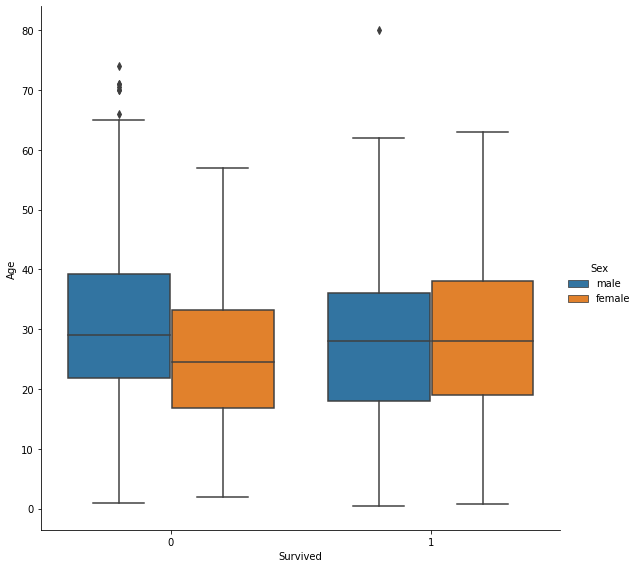

In [4]:
sns.catplot(data=df_train, x='Survived', y='Age', hue='Sex', kind='box', height=8)
plt.show()

- Checking `train` dataset as `pandas.DataFrame`

In [5]:
df_train.isna().sum().sort_values(ascending=False).head()

Cabin       687
Age         177
Embarked      2
Survived      0
Pclass        0
dtype: int64

### 3. Loading the `test` dataset
- Leaving out `Name` and `Ticket`

In [6]:
df_test = pd.read_csv('test.csv').set_index('PassengerId')
df_test.drop(['Name', 'Ticket'], axis=1, inplace=True)
print ('The shape of df_test is: ', df_test.shape)
df_test.head(5)

The shape of df_test is:  (418, 8)


,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
PassengerId,,,,,,,,
892,3,male,34.5,0,0,7.8292,NaN,Q
893,3,female,47.0,1,0,7.0000,NaN,S
894,2,male,62.0,0,0,9.6875,NaN,Q
895,3,male,27.0,0,0,8.6625,NaN,S
896,3,female,22.0,1,1,12.2875,NaN,S


### 4. Scaling and category encoder 
- Leaving out `Survived`, `Name` and `Ticket` on `train`
- Choosing numeric feature

In [7]:
df_train.drop(['Survived', 'Name', 'Ticket'], axis=1, inplace=True)
print ('The shape of df_test is: ', df_test.shape)
df_test.head(5)

The shape of df_test is:  (418, 8)


,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
PassengerId,,,,,,,,
892,3,male,34.5,0,0,7.8292,NaN,Q
893,3,female,47.0,1,0,7.0000,NaN,S
894,2,male,62.0,0,0,9.6875,NaN,Q
895,3,male,27.0,0,0,8.6625,NaN,S
896,3,female,22.0,1,1,12.2875,NaN,S


In [8]:
select_numeric_features = make_column_selector(dtype_include=np.number)

In [9]:
numeric_features = select_numeric_features(df_train)

print(f'N numeric_features: {len(numeric_features)} \n')
print(', '.join(numeric_features))

N numeric_features: 5 

Pclass, Age, SibSp, Parch, Fare


#### Impute missing features values using a descriptive statistic `mean`, and normalize numeric features using `StandardScaler`
- `train` & `test` sets

In [10]:
df_train.fillna(np.nan, inplace=True)
df_test.fillna(np.nan, inplace=True)

numeric_pipeline = make_pipeline(SimpleImputer(strategy='mean'), StandardScaler())

##### Cardinality categorical features

In [11]:
df_train.nunique()

Pclass        3
Sex           2
Age          88
SibSp         7
Parch         7
Fare        248
Cabin       147
Embarked      3
dtype: int64

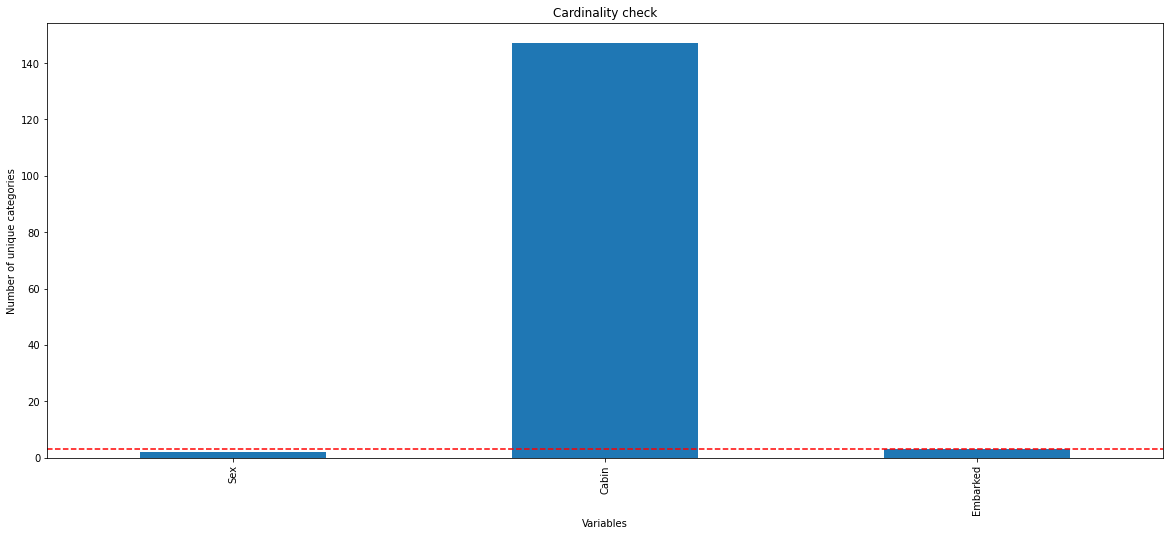

In [12]:
df_train_object = df_train.select_dtypes(include="object")
df_train_object.nunique().plot.bar(figsize=(20,8))
plt.ylabel('Number of unique categories')
plt.xlabel('Variables')
plt.title('Cardinality check')
plt.axhline(y = 3, color= 'r', linestyle='--')
plt.show()

#### Categorical with moderate-to-low cardinality

In [13]:
MAX_OH_CARDINALITY = 3

def select_oh_features(df):
    
    hc_features = df.select_dtypes(['object', 'category']).apply(lambda col: col.nunique())\
        .loc[lambda x: x <= MAX_OH_CARDINALITY].index.tolist()
        
    return hc_features

oh_features = select_oh_features(df_train)

print(f'N oh_features: {len(oh_features)} \n')
print(', '.join(oh_features))

N oh_features: 2 

Sex, Embarked


In [14]:
oh_pipeline = make_pipeline(SimpleImputer(strategy='constant'), OneHotEncoder(handle_unknown='ignore'))

#### Categorical with high cardinality

In [15]:
def select_hc_features(df):
    
    hc_features = df.select_dtypes(['object', 'category']).apply(lambda col: col.nunique())\
        .loc[lambda x: x > MAX_OH_CARDINALITY].index.tolist()
        
    return hc_features

hc_features = select_hc_features(df_train)

print(f'N hc_features: {len(hc_features)} \n')
print(', '.join(hc_features))

N hc_features: 1 

Cabin


In [16]:
hc_pipeline = make_pipeline(ce.GLMMEncoder())

#### Putting it all together

In [17]:
column_transformer = ColumnTransformer(transformers = 
                                       [('numeric_pipeline', numeric_pipeline, select_numeric_features),
                                        ('oh_pipeline', oh_pipeline, select_oh_features),
                                        ('hc_pipeline', hc_pipeline, select_hc_features)],
                      remainder='drop')

In [18]:
X_train_trsf = column_transformer.fit_transform(df_train, y_train_raw)
X_test_trsf = column_transformer.transform(df_test)

print(X_train_trsf.shape)
print(X_test_trsf.shape)

(891, 12)
(418, 12)


- Back to `Pandas` to check `train` set transformed

In [19]:
back_df_train = pd.DataFrame(X_train_trsf)
back_df_train.head(2)

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.827377,-0.592481,0.432793,-0.473674,-0.502445,0.0,1.0,0.0,0.0,1.0,0.0,-1.600651
1,-1.566107,0.638789,0.432793,-0.473674,0.786845,1.0,0.0,1.0,0.0,0.0,0.0,0.341921


In [20]:
back_df_train.isna().sum().sort_values(ascending=False).head()

0    0
1    0
2    0
3    0
4    0
dtype: int64

- Checking `train` set transformed as `numpy.ndarray`

In [21]:
print(np.sum(np.isnan(X_train_trsf)))

0


In [22]:
print("X_train_trsf Type     :", type(X_train_trsf))
print(f"X_train_trsf Shape    : {X_train_trsf.shape}")
print("X_train_trsf Dimension:", X_train_trsf.ndim)

X_train_trsf Type     : <class 'numpy.ndarray'>
X_train_trsf Shape    : (891, 12)
X_train_trsf Dimension: 2


Normalize and encoded `train` examples are stored in a Numpy matriz `X_train_trsf`.

In [23]:
print("First element of X_train_trsf are:\n", X_train_trsf[:1])

First element of X_train_trsf are:
 [[ 0.82737724 -0.5924806   0.43279337 -0.47367361 -0.50244517  0.
   1.          0.          0.          1.          0.         -1.60065053]]


- Checking `test` set transformed as `numpy.ndarray`

In [24]:
print(np.sum(np.isnan(X_test_trsf)))

0


In [25]:
print("X_test_trsf Type     :", type(X_test_trsf))
print(f"X_test_trsf Shape    : {X_test_trsf.shape}")
print("X_test_trsf Dimension:", X_test_trsf.ndim)

X_test_trsf Type     : <class 'numpy.ndarray'>
X_test_trsf Shape    : (418, 12)
X_test_trsf Dimension: 2


Normalize and encoder `test` examples are stored in a Numpy matriz `X_test_trsf`.

In [26]:
print("First element of X_test_trsf are:\n", X_test_trsf[:1])

First element of X_test_trsf are:
 [[ 0.82737724  0.36944878 -0.4745452  -0.47367361 -0.49078316  0.
   1.          0.          1.          0.          0.         -1.60065053]]


## 2 - Logistic Regression

In this part of the exercise, we will build a logistic regression model to predict `Survived` (contains your binary predictions: 1 for survived, 0 for deceased).

### 2.1  Sigmoid function

- With this model, we can then predict if unseen data (passenger) will be survived the sinking of the Titanic based on their features.

In [27]:
def sigmoid(z):
    """
    Compute the sigmoid of z   
    """

    g = 1/(1+np.exp(-z))
    return g

When you are finished, try testing a few values by calling `sigmoid(x)` in the cell below. 
- For large positive values of x, the sigmoid should be close to 1, while for large negative values, the sigmoid should be close to 0. 
- Evaluating `sigmoid(0)` should give you exactly 0.5. 


In [28]:
print ("sigmoid(0) = " + str(sigmoid(0)))

sigmoid(0) = 0.5


### 2.2 Cost function for logistic regression

In [29]:
def compute_cost(X, y, w, b, lambda_= 1):
    """
    Computes the cost over all examples
    lambda_: unused placeholder
    """

    m, n = X.shape
    
    loss_sum = 0
    for i in range(m):
        z = np.dot(X[i],w) + b
        f_wb_i = sigmoid(z)
        loss = -y[i]*np.log(f_wb_i) - (1-y[i])*np.log(1-f_wb_i)
        loss_sum += loss
        total_cost = loss_sum/m

    return total_cost

Run the cells below to check your implementation of the `compute_cost` function with two different initializations of the parameters $w$

In [30]:
m, n = X_train_trsf.shape

# Compute and display cost with w initialized to zeroes
initial_w = np.zeros(n)
initial_b = 0.
cost = compute_cost(X_train_trsf, y_train_raw, initial_w, initial_b)
print('Cost at initial w (zeros): {:.3f}'.format(cost))

Cost at initial w (zeros): 0.693


In [31]:
# Compute and display cost with non-zero w
test_w = np.array([0.1, 0.2, 0.1, 0.2, 0.1, 0.2, 0.1, 0.2, 0.1, 0.2, 0.1, 0.2])
test_b = -24.
cost = compute_cost(X_train_trsf, y_train_raw, test_w, test_b)

print('Cost at test w,b: {:.3f}'.format(cost))

Cost at test w,b: 9.142


### 2.3 Gradient for logistic regression

In [32]:
def compute_gradient(X, y, w, b, lambda_=None): 
    """
    Computes the gradient for logistic regression 
    lambda_: unused placeholder
    """
    
    m, n = X.shape
    dj_dw = np.zeros(w.shape)
    dj_db = 0.

    for i in range(m):
        f_wb_i = sigmoid(np.dot(X[i],w) + b)
        error_i = f_wb_i - y[i]
        for j in range(n): 
            dj_dw[j] = dj_dw[j] + error_i*X[i,j]         # dj_dw[j] += error_i + X[i,j]
        dj_db = dj_db + error_i                          # dj_db += error_i
            
    dj_dw = dj_dw/m
    dj_db = dj_db/m

    return dj_db, dj_dw

Run the cells below to check your implementation of the `compute_gradient` function with two different initializations of the parameters $w$

In [33]:
# Compute and display gradient with w initialized to zeroes
initial_w = np.zeros(n)
initial_b = 0.

dj_db, dj_dw = compute_gradient(X_train_trsf, y_train_raw, initial_w, initial_b)
print(f'dj_db at initial w (zeros):{dj_db}' )
print(f'dj_dw at initial w (zeros):{dj_dw.tolist()}' )

dj_db at initial w (zeros):0.11616161616161616
dj_dw at initial w (zeros):[0.16460986651951043, 0.033949229535758484, 0.017178013563472334, -0.039697957570735354, -0.12513313244901056, -0.08529741863075196, 0.20145903479236812, -0.010101010101010102, 0.009539842873176206, 0.11784511784511785, -0.001122334455667789, -0.2974337824004244]


In [34]:
# Compute and display cost and gradient with non-zero w
test_w = np.array([0.2, -0.5, 0.2, -0.5, 0.2, -0.5, 0.2, -0.5, 0.2, -0.5, 0.2, -0.5])
test_b = -24
dj_db, dj_dw  = compute_gradient(X_train_trsf, y_train_raw, test_w, test_b)

print('dj_db at test_w:', dj_db)
print('dj_dw at test_w:', dj_dw.tolist())

dj_db at test_w: -0.3838383837756686
dj_dw at test_w: [0.1646098665465298, 0.03394922951054215, 0.01717801357645936, -0.03969795757964593, -0.1251331324589447, -0.2615039281580731, -0.12233445561759601, -0.10437710436832491, -0.03367003365846981, -0.24354657683756323, -0.0022446689113112235, 0.3129230201775672]


### 2.4 Learning parameters using gradient descent 

Similar to the previous exercise, we will now find the optimal parameters of a logistic regression model by using gradient descent. 
- A good way to verify that gradient descent is working correctly is to look
at the value of $J(\mathbf{w},b)$ and check that it is decreasing with each step. 

- Assuming you have implemented the gradient and computed the cost correctly, your value of $J(\mathbf{w},b)$ should never increase, and should converge to a steady value by the end of the algorithm.

In [35]:
def gradient_descent(X, y, w_in, b_in, cost_function, gradient_function, alpha, num_iters, lambda_): 
    """
    Performs batch gradient descent to learn theta. Updates theta by taking 
    num_iters gradient steps with learning rate alpha
    """
    
    # number of training examples
    m = len(X)
    
    # An array to store cost J and w's at each iteration primarily for graphing later
    J_history = []
    w_history = []
    
    for i in range(num_iters):

        # Calculate the gradient and update the parameters
        dj_db, dj_dw = gradient_function(X, y, w_in, b_in, lambda_)   

        # Update Parameters using w, b, alpha and gradient
        w_in = w_in - alpha * dj_dw               
        b_in = b_in - alpha * dj_db              
       
        # Save cost J at each iteration
        if i<100000:      # prevent resource exhaustion 
            cost =  cost_function(X, y, w_in, b_in, lambda_)
            J_history.append(cost)

        # Print cost every at intervals 10 times or as many iterations if < 10
        if i% math.ceil(num_iters/10) == 0 or i == (num_iters-1):
            w_history.append(w_in)
            print(f"Iteration {i:4}: Cost {float(J_history[-1]):8.2f}   ")
        
    return w_in, b_in, J_history, w_history #return w and J,w history for graphing

Now let's run the gradient descent algorithm above to learn the parameters for our dataset.

**Note**

The code block below takes a couple of minutes to run, especially with a non-vectorized version. You can reduce the `iterations` to test your implementation and iterate faster. If you have time, try running 100,000 iterations for better results.

In [36]:
np.random.seed(1)
intial_w = 0.01 * (np.random.rand(12).reshape(-1,1) - 0.5)
initial_b = -8


# Some gradient descent settings
iterations = 10000
alpha = 0.03

w,b, J_history,_ = gradient_descent(X_train_trsf, y_train_raw, initial_w, initial_b, 
                                   compute_cost, compute_gradient, alpha, iterations, 0)

Iteration    0: Cost     3.06   
Iteration 1000: Cost     0.50   
Iteration 2000: Cost     0.44   
Iteration 3000: Cost     0.42   
Iteration 4000: Cost     0.42   
Iteration 5000: Cost     0.41   
Iteration 6000: Cost     0.41   
Iteration 7000: Cost     0.41   
Iteration 8000: Cost     0.41   
Iteration 9000: Cost     0.41   
Iteration 9999: Cost     0.41   


### 2.5 Evaluating logistic regression

We can evaluate the quality of the parameters we have found by seeing how well the learned model predicts on our training set. 

You will implement the `predict` function below to do this.


##### Threshold:

  if $f(x^{(i)}) > 0.6$, predict $y^{(i)}=1$
  
  if $f(x^{(i)}) <= 0.6$, predict $y^{(i)}=0$
- `>0.6` gave us better results rather than `>=/>0.5` or `>0.7`

In [37]:
def predict(X, w, b): 
    """
    Predict whether the label is 0 or 1 using learned logistic
    regression parameters w
    """
    
    # number of training examples
    m, n = X.shape   
    p = np.zeros(m)
   
    # Loop over each example
    for i in range(m):   
        z_wb = np.dot(X[i],w)
        
        # Add bias term 
        z_wb += b
        
        # Calculate the prediction for this example
        f_wb = sigmoid(z_wb)

        # Apply the threshold
        p[i] = f_wb > 0.6
        
    return p

Once you have completed the function `predict`, let's run the code below to report the training accuracy of your classifier by computing the percentage of examples it got correct.

In [38]:
# Test your predict code
np.random.seed(1)
tmp_w = np.random.randn(2)
tmp_b = 0.3    
tmp_X = np.random.randn(4, 2) - 0.5

tmp_p = predict(tmp_X, tmp_w, tmp_b)
print(f'Output of predict: shape {tmp_p.shape}, value {tmp_p}')

Output of predict: shape (4,), value [0. 1. 1. 1.]


### 2.6 Metrics
Now let's use this to compute the `Accuracy` & `ROC` on the training set

In [39]:
#Compute accuracy on our training set
p_train = predict(X_train_trsf, w,b)
print('Train Accuracy: %f'%(np.mean(p_train == y_train_raw) * 100))

#Compute accuracy on our training set with Scikit-learn
print('sklearn.metrics - Train Accuracy: %f'%(accuracy_score(y_train_raw, p_train) * 100))
print('sklearn.metrics - Train ROC: %f'%(roc_auc_score(y_train_raw, p_train) * 100))

Train Accuracy: 83.838384
sklearn.metrics - Train Accuracy: 83.838384
sklearn.metrics - Train ROC: 81.538203


## 3 - Make predictions on `test` set

In [40]:
p_test = predict(X_test_trsf, w,b)
print("Elements of p_test are:\n", p_test[:])

Elements of p_test are:
 [0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0.
 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 1. 0. 1. 1. 0. 1. 0.
 1. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 1. 0. 1. 1. 1. 0.
 1. 1. 1. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1. 0. 1. 0. 0. 0.
 1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 1. 1. 1. 0. 0. 1. 1. 1.
 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0.
 1. 1. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 1. 0. 1. 1. 0. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 1. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 1.
 1. 0. 1. 0. 0. 0. 1. 0. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1.
 0. 0. 0. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 1. 1. 0. 0. 1.
 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0.
 0. 1. 1. 1. 0. 0. 0. 0. 0

In [41]:
submission = pd.DataFrame(dict(PassengerId=df_test.index, Survived=p_test))
submission.head()

,PassengerId,Survived
0,892,0.0
1,893,0.0
2,894,0.0
3,895,0.0
4,896,0.0


In [42]:
submission.describe()

,PassengerId,Survived
count,418.000000,418.000000
mean,1100.500000,0.368421
std,120.810458,0.482954
min,892.000000,0.000000
25%,996.250000,0.000000
50%,1100.500000,0.000000
75%,1204.750000,1.000000
max,1309.000000,1.000000


In [43]:
submission = submission.astype(int)

In [ ]:
#submission.to_csv('submission.csv', index=False, header=True)

## Acknowledgments

- Machine Learning Specialization offered jointly by DeepLearning.AI and Stanford University on Coursera.
- The dataset was derived from **Kaggle** [Titanic - Machine Learning from Disaster](https://www.kaggle.com/competitions/titanic).
- Category Encoder: Scikit-Learn ColumnTransformer approach from [Kyle Gilde](https://www.kaggle.com/code/kylegilde/building-columntransformers-dynamically) on **Kaggle**

>Let me know if you have any comment/feedback/recommendations.  Thanks!